In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

<h3>Horizontal Projection

In [2]:
def horizontal_projection(thresh1):
    row_matrix = [] #it containing all row segements
    segemetation = []
    count = 0
    i = 0
    copy_image  = thresh1
    for p in range(thresh1.shape[0]):
        if(copy_image[i].sum() == 0):
            count = count  + 1
            i = i+1
            if(count == 5):
                segemetation.append(copy_image[0:i,:])
                copy_image = np.delete(copy_image,np.s_[0:i], axis = 0)
                count = 0
                i = 0
        else:
            count = 0
            i = i + 1
    m = len(segemetation)
    for i in range(m):
        if(segemetation[i].sum() > 0):
            row_matrix.append(segemetation[i])
    return row_matrix

<h3>Vertical Projection|

In [3]:
def vertical_projection(image):
    row_matrix = []
    row = image
    segmentation = []
    count = 0
    i = 0
    for p in range(image.shape[1]):
        if(row[:,i].sum() == 0):
            count += 1
            i += 1
            if(count == 5):
                segmentation.append(row[:,0:i])
                row = np.delete(row,np.s_[0:i],axis = 1)
                count = 0
                i = 0
        else:
            count = 0
            i += 1
    m = len(segmentation)
    for i in range(m):
        if(segmentation[i].sum() > 0):
            row_matrix.append(segmentation[i])
    return row_matrix

<h3> Image crop

In [4]:
def crop(thresh1):
    #Top adjusting
    try:
        i = 0
        while(thresh1[i].sum() == 0):
            if(thresh1[i+8].sum() == 0):
                thresh1 = np.delete(thresh1,0,0)
            else:
                break
    except:
        pass
    #Bottom adjusting
    try:
        i = thresh1.shape[0] -1
        while(thresh1[i].sum() == 0):
            if(thresh1[i-8].sum() == 0):
                thresh1 = np.delete(thresh1,i,0)
                i = i -1
            else:
                break
    except:
        pass
    #right part of matrix is adjusting
    try:
        i = thresh1.shape[1] -1
        s = thresh1.sum(axis = 0)
        p = -1
        while(s[p] == 0):
            if(s[p-8] == 0):
                thresh1 = np.delete(thresh1,-1, axis = 1)
                s = np.delete(s, -1, axis=0)
            else:
                break
    except:
        pass
    #left side adusting
    try:
        i = thresh1.shape[1] -1
        s = thresh1.sum(axis = 0)
        p = 0
        while(s[p] == 0):
            if(s[p + 8] == 0):
                thresh1 = np.delete(thresh1,1, axis = 1)
                s = np.delete(s, 1, axis=0)
            else:
                break
    except:
        pass
    return thresh1

<h3>Apply Threshold inverse

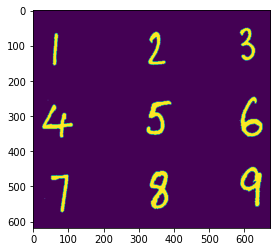

In [5]:
image = cv.imread('3.jpeg',0)
#ret,thresh1 = cv.threshold(image, 127, 255, cv.THRESH_BINARY_INV)
#(thresh, thresh1) = cv.threshold(image, 128, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
thresh1 = cv.threshold(image, 127, 255, cv.THRESH_BINARY_INV)[1]
#thresh1 = tf.keras.utils.normalize(thresh1, axis = 1)
kernel = np.ones((6,6),np.uint8)
opening = cv.morphologyEx(thresh1, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(thresh1, cv.MORPH_CLOSE, kernel)
thresh = crop(opening)
#newimg = tf.keras.utils.normalize(thresh1, axis = 1)
plt.imshow(thresh1)
#cv.imshow('Original',image)
#cv.waitKey()

<h3>Matrix Prediction

In [6]:
matrix = []
horizontal = horizontal_projection(thresh)
#cv.imshow('Original',horizontal[2])
#cv.waitKey()
no_rows = len(horizontal)
for i in range(no_rows):
    vertical = vertical_projection(horizontal[i])
    no_colmun = len(vertical)
    for j in range(no_colmun):
        vertical[j] = crop(vertical[j])
    matrix.append(vertical)
#cv.imshow('Original',matrix[2][2])
#cv.waitKey()

In [7]:
#from tensorflow.keras.models import load_model
#import tensorflow as tf
model = load_model('cnn_model.h5')
my_rows, my_cols = (no_rows, no_colmun)
my_array = [[0]*my_cols]*my_rows
my_array = np.array(my_array)
for i in range(3):
    for j in range(3):
        th = matrix[i][j]
        resized = cv.resize(th,(28,28), interpolation = cv.INTER_AREA)
        newimg = tf.keras.utils.normalize(resized, axis = 1)
        newimg = np.array(newimg).reshape(-1,28,28,1)
        prediction = model.predict(newimg)
        value = np.argmax(prediction)
        my_array[i][j] = value
print('Predicted matrix is')
my_array

Predicted matrix is


array([[2, 2, 3],
       [4, 5, 0],
       [1, 8, 9]])

In [13]:
from numpy import linalg as LA
w, v = LA.eig(my_array)
print("Eigen values :")
print(w)
print('Eigen Vectors :')
print(v)
print("Transpose")
print(np.transpose(my_array))
print("Inverse")
try:
    print(np.linalg.inv(my_array))
except:
    print('Matrix is sigular, Can not find Inverse')
print("Determinant : ")
print(np.linalg.det(my_array))

Eigen values :
[11.28247886+0.j         2.35876057+1.7919029j  2.35876057-1.7919029j]
Eigen Vectors :
[[ 0.34233996+0.j          0.28972461-0.38096049j  0.28972461+0.38096049j]
 [ 0.2179649 +0.j         -0.56851576+0.19124239j -0.56851576-0.19124239j]
 [ 0.91394456+0.j          0.64120584+0.j          0.64120584-0.j        ]]
Transpose
[[2 4 1]
 [2 5 8]
 [3 0 9]]
Inverse
[[ 0.45454545  0.06060606 -0.15151515]
 [-0.36363636  0.15151515  0.12121212]
 [ 0.27272727 -0.14141414  0.02020202]]
Determinant : 
98.99999999999999
